In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision, Coalescence
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot
import matplotlib

from PySDM.initialisation.spectra import Exponential
from PySDM.physics.collision_kernels import Golovin, Geometric, ConstantK
from PySDM.physics.coalescence_efficiencies import Berry1967, ConstEc, Schlottke2010
from PySDM.physics.breakup_efficiencies import ConstEb
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS, ExponFrag, Gaussian
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

In [12]:
def run_box2(k, step):

    @strict
    class Settings:

        def __init__(self):
            self.formulae = Formulae()
            self.n_sd = 2**k
            self.n_part = 100 / si.cm**3
            self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
            self.dv = 1 * si.m**3
            self.norm_factor = self.n_part * self.dv
            self.rho = 1000 * si.kilogram / si.metre**3
            self.dt = 1 * si.seconds
            self.adaptive = False
            self.seed = 44
            self._steps = [0]
            self.kernel = Geometric()
            self.coal_eff = Berry1967()
            self.fragmentation = ExponFrag(scale=250.0 * si.micrometres)
            self.break_eff = ConstEb(1.0) # no "bouncing"
            self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
            self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(2000 * si.um), num=128, endpoint=True)
            self.radius_range = [0 * si.um, 1e6 * si.um]

        @property
        def output_steps(self):
            return [int(step/self.dt) for step in self._steps]
    settings = Settings()
    backend = CPU

    builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
    breakup = Collision(settings.kernel, settings.coal_eff, settings.break_eff, settings.fragmentation, adaptive=settings.adaptive)
    builder.add_dynamic(breakup)
    products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
    core = builder.build(attributes, products)

    # run
    core.run(step - core.n_steps)

    x=settings.radius_bins_edges[:-1] / si.micrometres, 
    y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho
    
    return (x,y)

In [13]:
def run_box2_nobreak(k, step):

    @strict
    class Settings:

        def __init__(self):
            self.formulae = Formulae()
            self.n_sd = 2**k
            self.n_part = 100 / si.cm**3
            self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
            self.dv = 1 * si.m**3
            self.norm_factor = self.n_part * self.dv
            self.rho = 1000 * si.kilogram / si.metre**3
            self.dt = 1 * si.seconds
            self.adaptive = False
            self.seed = 45
            self._steps = [0]
            self.kernel = Geometric()
            self.coal_eff = Berry1967()
            self.fragmentation = ExponFrag(scale=250.0 * si.micrometres)
            self.break_eff = ConstEb(1.0) # no "bouncing"
            self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
            self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(2000 * si.um), num=128, endpoint=True)
            self.radius_range = [0 * si.um, 1e6 * si.um]

        @property
        def output_steps(self):
            return [int(step/self.dt) for step in self._steps]
    settings = Settings()
    backend = CPU

    builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
    coal = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
    builder.add_dynamic(coal)
    products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
    core = builder.build(attributes, products)

    # run
    core.run(step - core.n_steps)

    x=settings.radius_bins_edges[:-1] / si.micrometres, 
    y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho
    
    return (x,y)

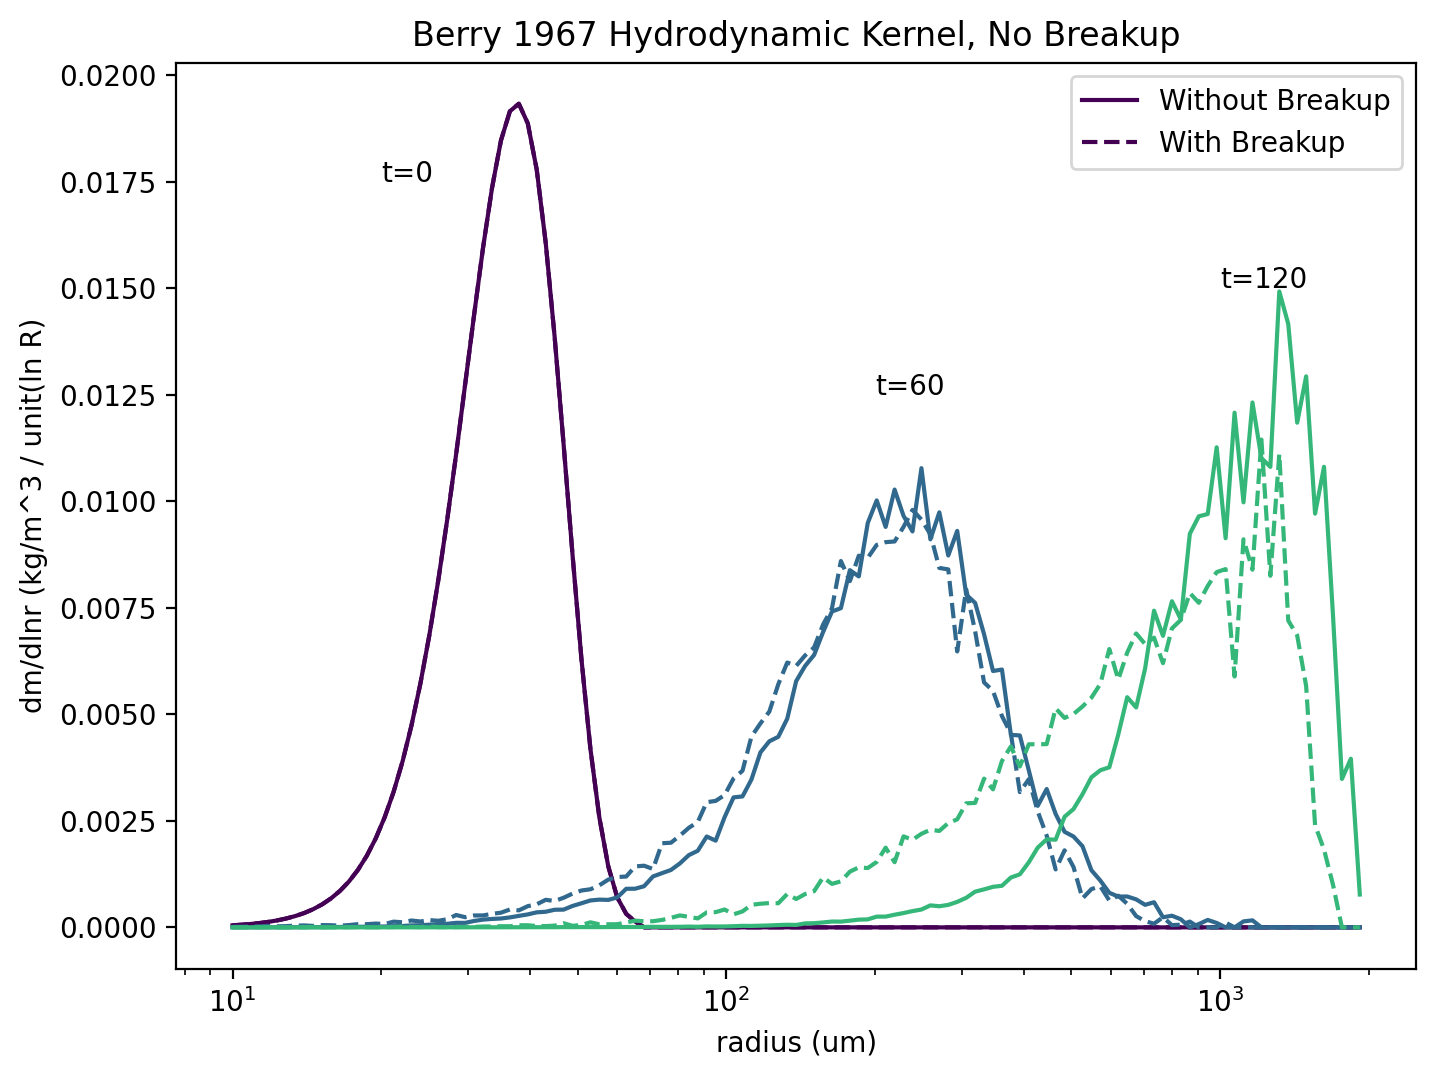

In [17]:
cmap = matplotlib.cm.get_cmap('viridis')
legend_entries = []
t_steps = [0, 60, 120]
pyplot.figure(figsize=(8,6),dpi=200)
for (i,step) in enumerate(t_steps):
    k=16
    (x,y) = run_box2_nobreak(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='-')
    legend_entries.append("Without Breakup")

    k=16
    (x,y) = run_box2(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='--')
    legend_entries.append("With Breakup")

pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr (kg/m^3 / unit(ln R)")
pyplot.legend(legend_entries[0:2])
pyplot.annotate('t=0',(20.0, 0.0175))
pyplot.annotate('t='+str(t_steps[1]),(200.0, 0.0125))
pyplot.annotate('t='+str(t_steps[2]),(1000.0, 0.015))
pyplot.title("Berry 1967 Hydrodynamic Kernel, No Breakup")
pyplot.savefig('breakup_matters.png')